In [ ]:
!pip install timm medmnist scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from medmnist import PneumoniaMNIST
from medmnist import INFO


In [ ]:
info = INFO['pneumoniamnist']
DataClass = PneumoniaMNIST

train_data = DataClass(split='train', download=True)
val_data   = DataClass(split='val', download=True)
test_data  = DataClass(split='test', download=True)


100%|██████████| 4.17M/4.17M [00:06<00:00, 603kB/s]


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),   # grayscale → 3 channel
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_data.transform = transform
val_data.transform   = transform
test_data.transform  = transform


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)
test_loader  = DataLoader(test_data, batch_size=32)


In [ ]:
model = timm.create_model(
    'swin_tiny_patch4_window7_224',
    pretrained=True,
    num_classes=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)


In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(10):
    # ---- TRAIN ----
    model.train()
    correct, total, train_loss = 0, 0, 0

    for x,y in train_loader:
        x,y = x.to(device), y.squeeze().long().to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += y.size(0)

    train_losses.append(train_loss/len(train_loader))
    train_accs.append(correct/total)

    # ---- VALIDATION ----
    model.eval()
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.squeeze().long().to(device)
            out = model(x)
            loss = criterion(out,y)

            val_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred==y).sum().item()
            total += y.size(0)

    val_losses.append(val_loss/len(val_loader))
    val_accs.append(correct/total)

    print(f"Epoch {epoch+1}: Train Acc={train_accs[-1]:.3f}, Val Acc={val_accs[-1]:.3f}")


Epoch 1: Train Acc=0.863, Val Acc=0.931
Epoch 2: Train Acc=0.927, Val Acc=0.943
Epoch 3: Train Acc=0.948, Val Acc=0.945
Epoch 4: Train Acc=0.961, Val Acc=0.964
Epoch 5: Train Acc=0.968, Val Acc=0.971
Epoch 6: Train Acc=0.969, Val Acc=0.945
Epoch 7: Train Acc=0.971, Val Acc=0.971
Epoch 8: Train Acc=0.979, Val Acc=0.973
Epoch 9: Train Acc=0.982, Val Acc=0.969
Epoch 10: Train Acc=0.982, Val Acc=0.966


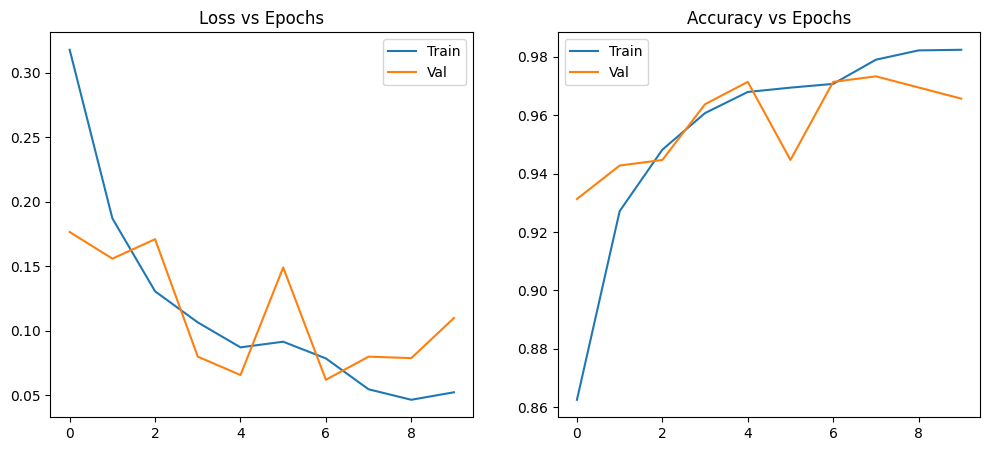

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train')
plt.plot(val_losses,label='Val')
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,label='Train')
plt.plot(val_accs,label='Val')
plt.title("Accuracy vs Epochs")
plt.legend()

plt.show()


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x,y in test_loader:
        x,y = x.to(device), y.squeeze().long().to(device)
        out = model(x)
        preds = out.argmax(1)

        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


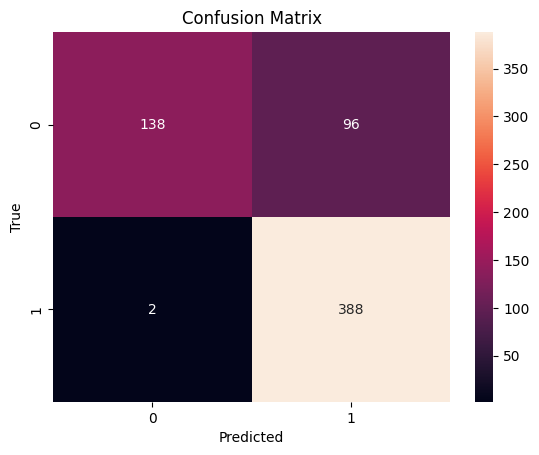

In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
print(classification_report(
    y_true, y_pred,
    target_names=["Normal","Pneumonia"],
    digits=4
))


              precision    recall  f1-score   support

      Normal     0.9857    0.5897    0.7380       234
   Pneumonia     0.8017    0.9949    0.8879       390

    accuracy                         0.8429       624
   macro avg     0.8937    0.7923    0.8129       624
weighted avg     0.8707    0.8429    0.8317       624



In [ ]:
acc = accuracy_score(y_true,y_pred)
prec,rec,f1,_ = precision_recall_fscore_support(y_true,y_pred,average='weighted')
prec_m,rec_m,f1_m,_ = precision_recall_fscore_support(y_true,y_pred,average='macro')

print("Test Accuracy:",acc)
print("Weighted: P,R,F1 =",prec,rec,f1)
print("Macro:    P,R,F1 =",prec_m,rec_m,f1_m)


Test Accuracy: 0.842948717948718
Weighted: P,R,F1 = 0.8706759149940968 0.842948717948718 0.8316578763812578
Macro:    P,R,F1 = 0.8936835891381346 0.7923076923076924 0.8129198839927068
